Cansu ASLAN
2210356079

In [2]:
from google.colab import drive
drive.mount('/content/drive');

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np
from torchvision import models


# Data augmentations for training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])    # ImageNet std
])

# Only resize and normalize for validation and test
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset Paths (bu dizinleri senin ayarlaman gerekiyor!)
train_dir = '/content/drive/MyDrive/food11/food11/train'
val_dir = '/content/drive/MyDrive/food11/food11/validation'
test_dir = '/content/drive/MyDrive/food11/food11/test'

# Datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=test_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# class names
class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['apple_pie', 'cheesecake', 'chicken_curry', 'french_fries', 'fried_rice', 'hamburger', 'hot_dog', 'ice_cream', 'omelette', 'pizza', 'sushi']


In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=11):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc1 = nn.Linear(512 * 7 * 7, 4096)
        self.fc2 = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = torch.flatten(x, 1) # batch_size x (512*7*7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

In [6]:
class ResNetCNN(nn.Module):
    def __init__(self, num_classes=11):
        super(ResNetCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.residual_block1 = ResidualBlock(128)  # Residual block after conv2

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.residual_block2 = ResidualBlock(512)  # Another residual block after conv4

        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc1 = nn.Linear(512 * 7 * 7, 4096)
        self.fc2 = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.residual_block1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.residual_block2(x)
        x = self.conv5(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
def train_one_epoch(model, optimizer, criterion, train_loader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, criterion, val_loader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


Training with batch size 32 and learning rate 0.001
Epoch [10/50] Train Loss: 2.2114, Train Acc: 0.2041, Val Loss: 2.3188, Val Acc: 0.1673
Epoch [20/50] Train Loss: 2.1171, Train Acc: 0.2441, Val Loss: 2.0969, Val Acc: 0.2582
Epoch [30/50] Train Loss: 2.0011, Train Acc: 0.3173, Val Loss: 1.9703, Val Acc: 0.3455
Epoch [40/50] Train Loss: 1.8664, Train Acc: 0.3618, Val Loss: 1.7453, Val Acc: 0.4145
Epoch [50/50] Train Loss: 1.7240, Train Acc: 0.4186, Val Loss: 1.6160, Val Acc: 0.4691


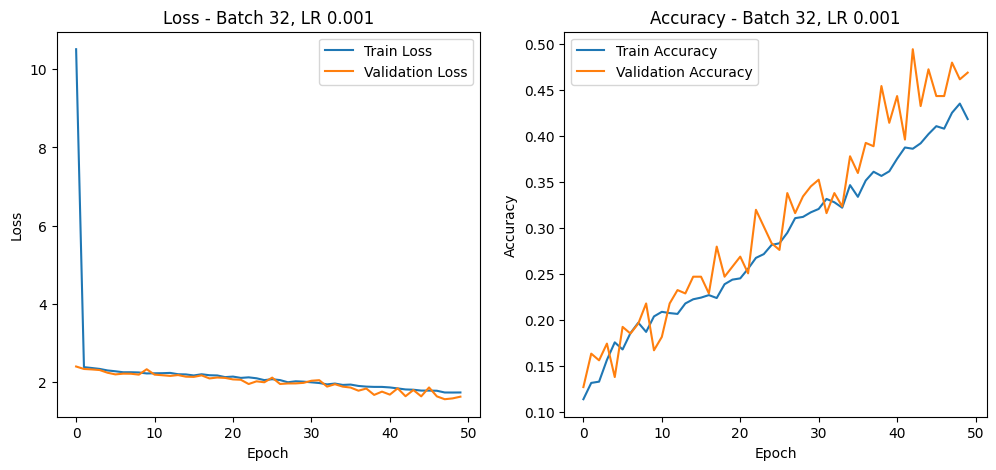


Training with batch size 32 and learning rate 0.0001
Epoch [20/50] Train Loss: 1.5047, Train Acc: 0.4923, Val Loss: 1.3680, Val Acc: 0.5927
Epoch [30/50] Train Loss: 1.3322, Train Acc: 0.5650, Val Loss: 1.1746, Val Acc: 0.6000
Epoch [40/50] Train Loss: 1.1830, Train Acc: 0.6109, Val Loss: 1.3432, Val Acc: 0.6218
Epoch [50/50] Train Loss: 1.0279, Train Acc: 0.6664, Val Loss: 1.4051, Val Acc: 0.5491


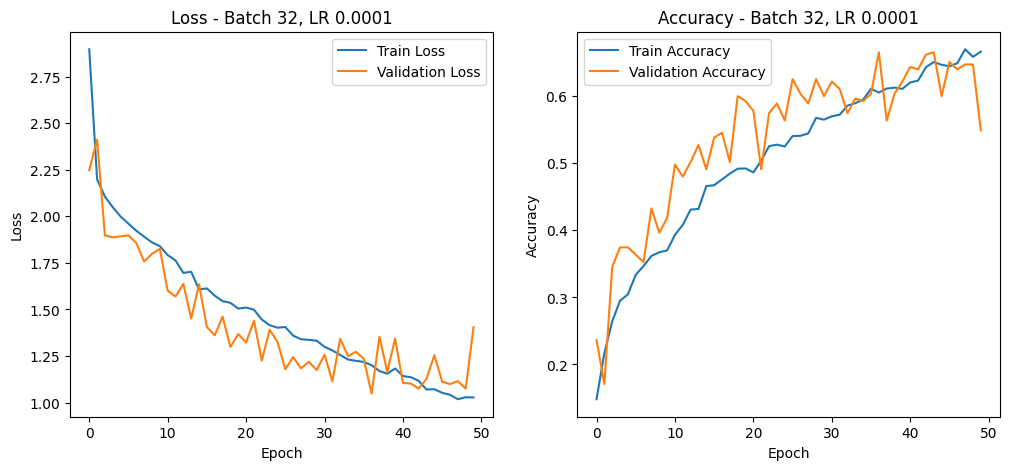


Training with batch size 32 and learning rate 0.0005
Epoch [10/50] Train Loss: 2.1622, Train Acc: 0.2323, Val Loss: 2.0332, Val Acc: 0.3018
Epoch [20/50] Train Loss: 1.9044, Train Acc: 0.3595, Val Loss: 1.9056, Val Acc: 0.3745
Epoch [30/50] Train Loss: 1.7938, Train Acc: 0.3936, Val Loss: 1.6270, Val Acc: 0.4618
Epoch [40/50] Train Loss: 1.6041, Train Acc: 0.4691, Val Loss: 1.3742, Val Acc: 0.5564
Epoch [50/50] Train Loss: 1.4427, Train Acc: 0.5241, Val Loss: 1.2406, Val Acc: 0.6218


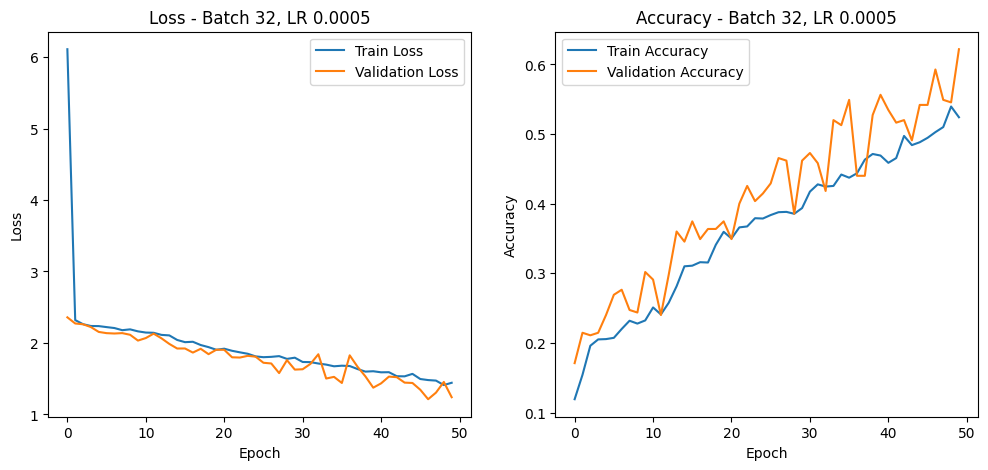


Training with batch size 64 and learning rate 0.001
Epoch [10/50] Train Loss: 2.2391, Train Acc: 0.1945, Val Loss: 2.2192, Val Acc: 0.2400
Epoch [20/50] Train Loss: 2.0213, Train Acc: 0.3036, Val Loss: 2.0244, Val Acc: 0.2727
Epoch [30/50] Train Loss: 1.9296, Train Acc: 0.3332, Val Loss: 2.0578, Val Acc: 0.3018
Epoch [40/50] Train Loss: 1.8159, Train Acc: 0.3841, Val Loss: 1.6695, Val Acc: 0.4000
Epoch [50/50] Train Loss: 1.6477, Train Acc: 0.4423, Val Loss: 1.7629, Val Acc: 0.4509


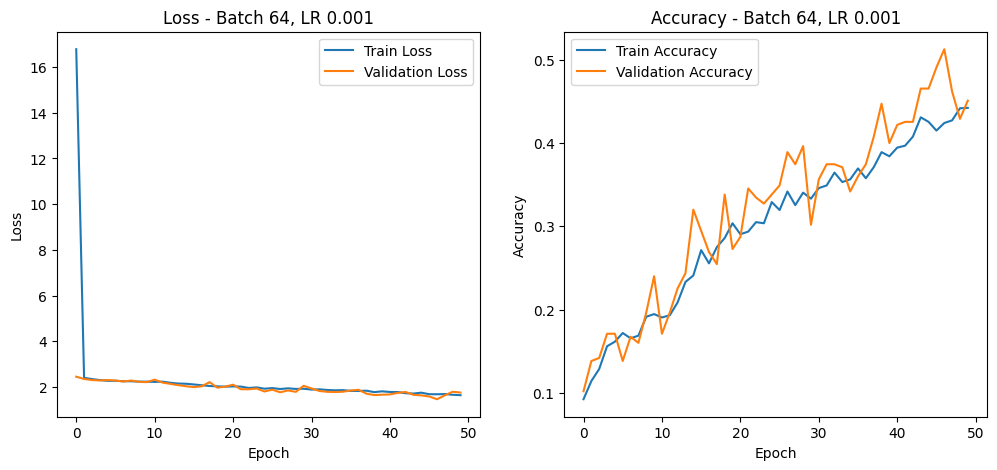


Training with batch size 64 and learning rate 0.0001
Epoch [10/50] Train Loss: 1.8589, Train Acc: 0.3527, Val Loss: 1.6857, Val Acc: 0.4800
Epoch [20/50] Train Loss: 1.5326, Train Acc: 0.4818, Val Loss: 1.4098, Val Acc: 0.5200
Epoch [30/50] Train Loss: 1.3205, Train Acc: 0.5641, Val Loss: 1.4967, Val Acc: 0.5345
Epoch [40/50] Train Loss: 1.1630, Train Acc: 0.6214, Val Loss: 1.1947, Val Acc: 0.5709
Epoch [50/50] Train Loss: 1.0207, Train Acc: 0.6659, Val Loss: 1.1157, Val Acc: 0.6327


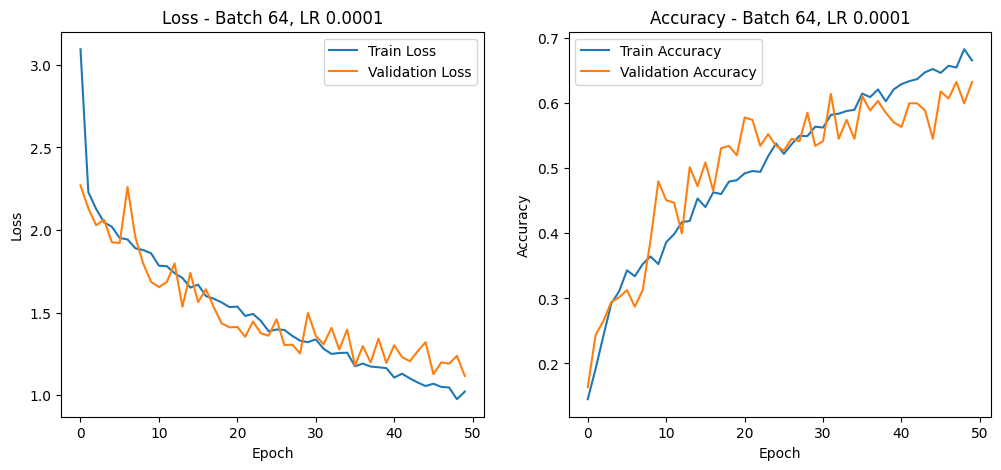


Training with batch size 64 and learning rate 0.0005
Epoch [10/50] Train Loss: 2.0834, Train Acc: 0.2850, Val Loss: 2.0759, Val Acc: 0.2909
Epoch [20/50] Train Loss: 1.8570, Train Acc: 0.3605, Val Loss: 1.7534, Val Acc: 0.4400
Epoch [30/50] Train Loss: 1.7035, Train Acc: 0.4209, Val Loss: 1.6135, Val Acc: 0.4691
Epoch [40/50] Train Loss: 1.5096, Train Acc: 0.4877, Val Loss: 1.4219, Val Acc: 0.5491
Epoch [50/50] Train Loss: 1.3505, Train Acc: 0.5568, Val Loss: 1.4948, Val Acc: 0.5164


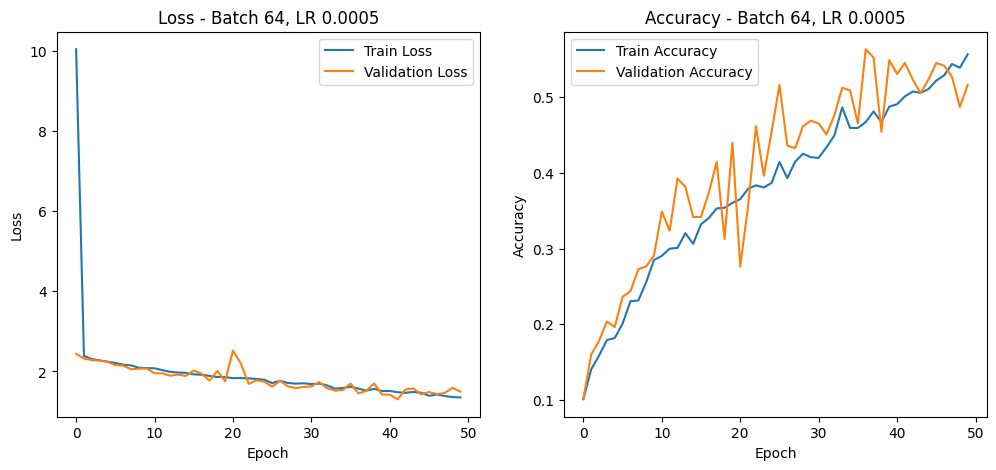

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Denenecek parametreler
learning_rates = [0.001, 0.0001, 0.0005]
batch_sizes = [32, 64]
num_epochs = 50

# Eğitim için dataloader'ı batch size'a göre yeniden oluşturacağız
def get_dataloaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, val_loader

# Ana eğitim
results = {}

for batch_size in batch_sizes:
    for lr in learning_rates:
        print(f"\nTraining with batch size {batch_size} and learning rate {lr}")

        model = SimpleCNN(num_classes=11).to(device)  # veya ResNetCNN kullanabilirsin
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        train_loader, val_loader = get_dataloaders(batch_size)

        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []

        for epoch in range(num_epochs):
            train_loss, train_acc = train_one_epoch(model, optimizer, criterion, train_loader, device)
            val_loss, val_acc = evaluate(model, criterion, val_loader, device)

            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Sonuçları kaydet
        key = f"batch{batch_size}_lr{lr}"
        results[key] = {
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies
        }

        # Her kombinasyon sonrası grafik çizelim
        plt.figure(figsize=(12,5))

        # Loss
        plt.subplot(1,2,1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title(f'Loss - Batch {batch_size}, LR {lr}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Accuracy
        plt.subplot(1,2,2)
        plt.plot(train_accuracies, label='Train Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.title(f'Accuracy - Batch {batch_size}, LR {lr}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()


Training with batch size 32 and learning rate 0.001
Epoch [10/50] Train Loss: 2.2661, Train Acc: 0.1659, Val Loss: 2.2404, Val Acc: 0.1855
Epoch [20/50] Train Loss: 2.1907, Train Acc: 0.1982, Val Loss: 2.0825, Val Acc: 0.2582
Epoch [30/50] Train Loss: 2.0873, Train Acc: 0.2564, Val Loss: 1.9608, Val Acc: 0.3055
Epoch [40/50] Train Loss: 1.9353, Train Acc: 0.3391, Val Loss: 1.7725, Val Acc: 0.4436
Epoch [50/50] Train Loss: 1.7279, Train Acc: 0.4277, Val Loss: 1.5083, Val Acc: 0.5236


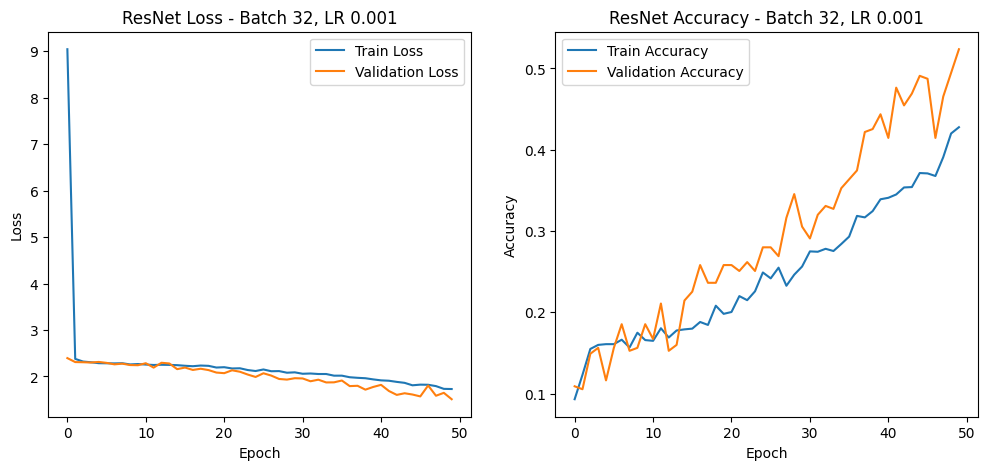


Training with batch size 32 and learning rate 0.0001
Epoch [10/50] Train Loss: 1.9428, Train Acc: 0.3282, Val Loss: 1.8003, Val Acc: 0.3964
Epoch [20/50] Train Loss: 1.5393, Train Acc: 0.4850, Val Loss: 1.3036, Val Acc: 0.5855
Epoch [30/50] Train Loss: 1.3286, Train Acc: 0.5464, Val Loss: 1.0282, Val Acc: 0.6800
Epoch [40/50] Train Loss: 1.1614, Train Acc: 0.6159, Val Loss: 0.9536, Val Acc: 0.6945
Epoch [50/50] Train Loss: 0.9877, Train Acc: 0.6718, Val Loss: 0.8029, Val Acc: 0.7273


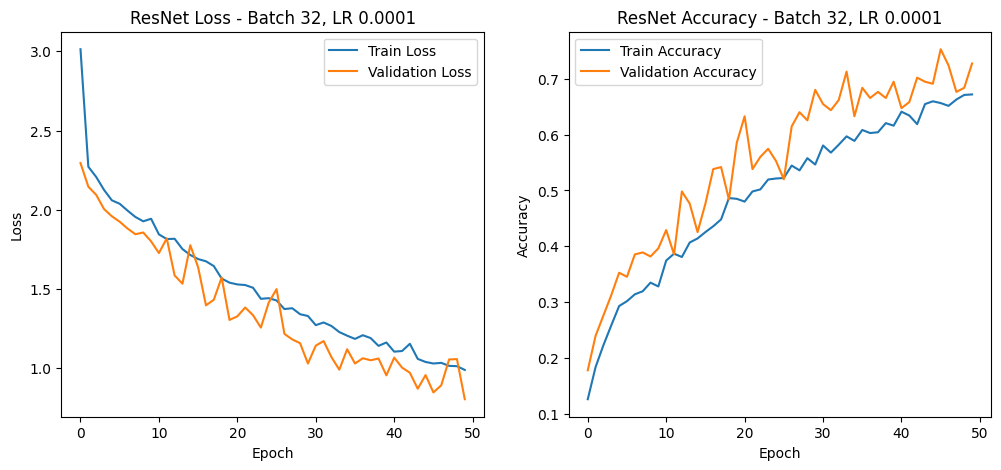


Training with batch size 32 and learning rate 0.0005
Epoch [10/50] Train Loss: 2.1214, Train Acc: 0.2432, Val Loss: 2.2002, Val Acc: 0.2400
Epoch [20/50] Train Loss: 1.9485, Train Acc: 0.3318, Val Loss: 1.7586, Val Acc: 0.4000
Epoch [30/50] Train Loss: 1.7438, Train Acc: 0.4068, Val Loss: 1.6320, Val Acc: 0.4691
Epoch [40/50] Train Loss: 1.5648, Train Acc: 0.4709, Val Loss: 1.3270, Val Acc: 0.5382
Epoch [50/50] Train Loss: 1.4256, Train Acc: 0.5155, Val Loss: 1.2580, Val Acc: 0.5673


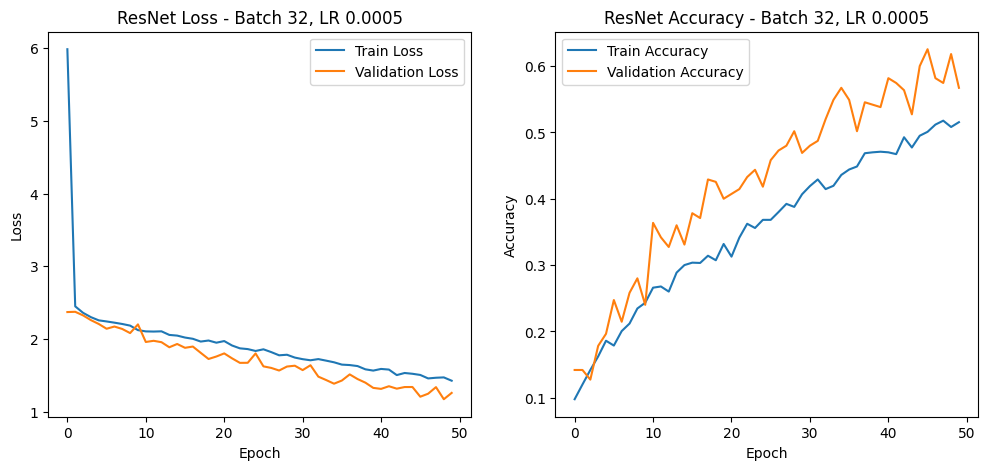


Training with batch size 64 and learning rate 0.001
Epoch [10/50] Train Loss: 2.2280, Train Acc: 0.1868, Val Loss: 2.1838, Val Acc: 0.1673
Epoch [20/50] Train Loss: 2.0908, Train Acc: 0.2723, Val Loss: 1.9867, Val Acc: 0.3273
Epoch [30/50] Train Loss: 1.9390, Train Acc: 0.3382, Val Loss: 1.9111, Val Acc: 0.3345
Epoch [40/50] Train Loss: 1.7909, Train Acc: 0.3845, Val Loss: 1.5694, Val Acc: 0.4764
Epoch [50/50] Train Loss: 1.6007, Train Acc: 0.4605, Val Loss: 1.7819, Val Acc: 0.4291


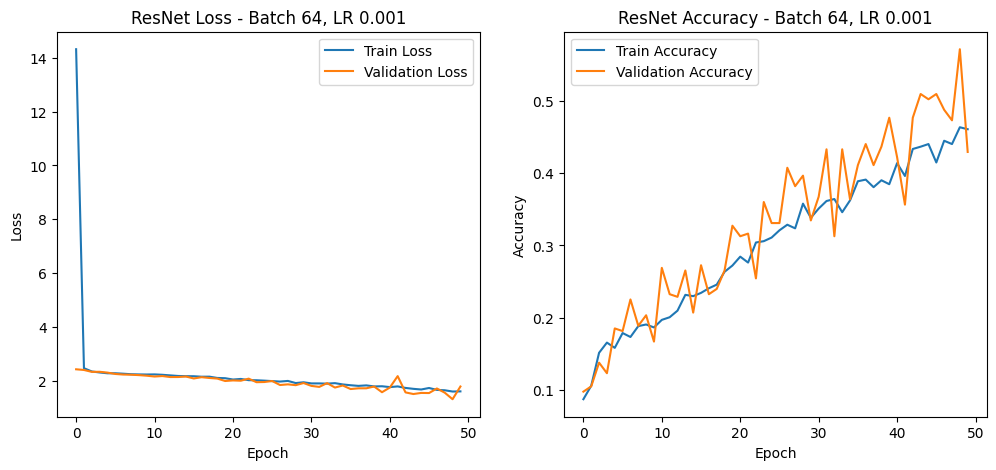


Training with batch size 64 and learning rate 0.0001
Epoch [10/50] Train Loss: 1.9353, Train Acc: 0.3350, Val Loss: 1.7944, Val Acc: 0.3891
Epoch [20/50] Train Loss: 1.6483, Train Acc: 0.4636, Val Loss: 1.6608, Val Acc: 0.4473
Epoch [30/50] Train Loss: 1.3897, Train Acc: 0.5305, Val Loss: 1.2209, Val Acc: 0.6255
Epoch [40/50] Train Loss: 1.1422, Train Acc: 0.6150, Val Loss: 1.4834, Val Acc: 0.5382
Epoch [50/50] Train Loss: 0.9703, Train Acc: 0.6795, Val Loss: 1.1060, Val Acc: 0.6436


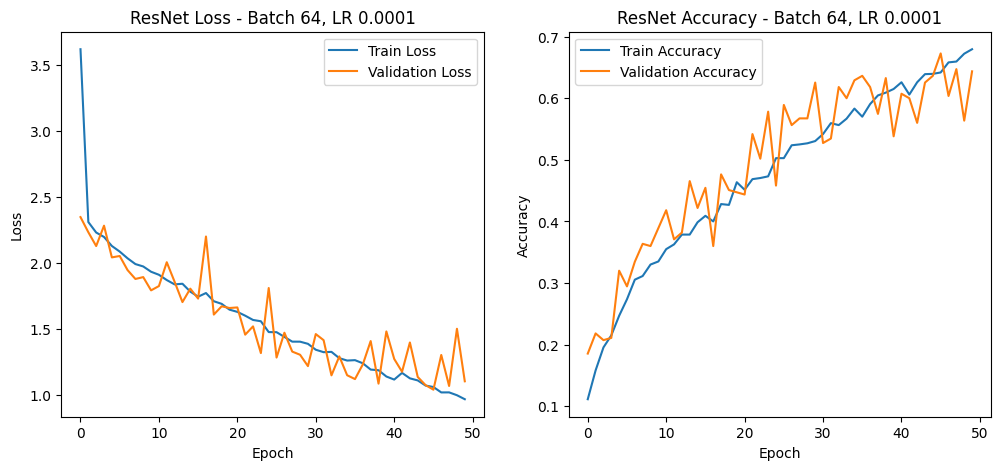


Training with batch size 64 and learning rate 0.0005
Epoch [10/50] Train Loss: 2.1333, Train Acc: 0.2609, Val Loss: 2.1107, Val Acc: 0.2618
Epoch [20/50] Train Loss: 1.9270, Train Acc: 0.3391, Val Loss: 1.8198, Val Acc: 0.4145
Epoch [30/50] Train Loss: 1.6841, Train Acc: 0.4268, Val Loss: 1.5269, Val Acc: 0.4982
Epoch [40/50] Train Loss: 1.5104, Train Acc: 0.4977, Val Loss: 1.3112, Val Acc: 0.5527
Epoch [50/50] Train Loss: 1.3569, Train Acc: 0.5418, Val Loss: 1.6412, Val Acc: 0.5127


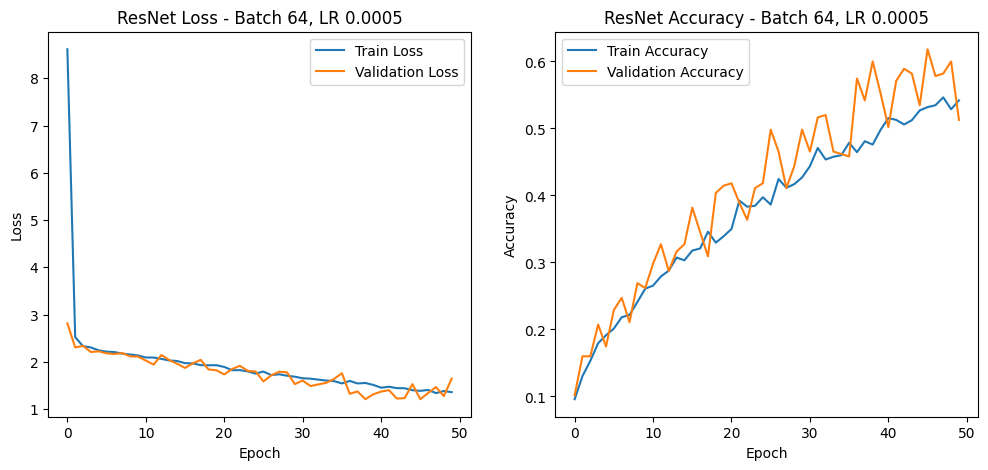

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Denenecek parametreler
learning_rates = [0.001, 0.0001, 0.0005]
batch_sizes = [32, 64]
num_epochs = 50

# Eğitim için dataloader'ı batch size'a göre yeniden oluşturacağız
def get_dataloaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, val_loader

# Ana eğitim
resnet_results = {}

for batch_size in batch_sizes:
    for lr in learning_rates:
        print(f"\nTraining with batch size {batch_size} and learning rate {lr}")

        model = ResNetCNN(num_classes=11).to(device)  # veya ResNetCNN kullanabilirsin
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        train_loader, val_loader = get_dataloaders(batch_size)

        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []

        for epoch in range(num_epochs):
            train_loss, train_acc = train_one_epoch(model, optimizer, criterion, train_loader, device)
            val_loss, val_acc = evaluate(model, criterion, val_loader, device)

            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Sonuçları kaydet
        key = f"batch{batch_size}_lr{lr}"
        resnet_results[key] = {
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies
        }

        # Her kombinasyon sonrası grafik çizelim
        plt.figure(figsize=(12,5))

        # Loss
        plt.subplot(1,2,1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title(f'ResNet Loss - Batch {batch_size}, LR {lr}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Accuracy
        plt.subplot(1,2,2)
        plt.plot(train_accuracies, label='Train Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.title(f'ResNet Accuracy - Batch {batch_size}, LR {lr}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()


In [10]:
# Find best ResNet model by validation accuracy
best_resnet_val_acc = 0.0
best_resnet_model_key = ''

for key, value in resnet_results.items():
    max_val_acc = max(value['val_accuracies'])
    if max_val_acc > best_resnet_val_acc:
        best_resnet_val_acc = max_val_acc
        best_resnet_model_key = key

print(f"Best ResNet Model: {best_resnet_model_key} with Validation Accuracy: {best_resnet_val_acc:.4f}")


Best ResNet Model: batch32_lr0.0001 with Validation Accuracy: 0.7527


Epoch [10/50] - Val Acc: 0.3709
Epoch [20/50] - Val Acc: 0.5636
Epoch [30/50] - Val Acc: 0.6291
Epoch [40/50] - Val Acc: 0.6255
Epoch [50/50] - Val Acc: 0.7455


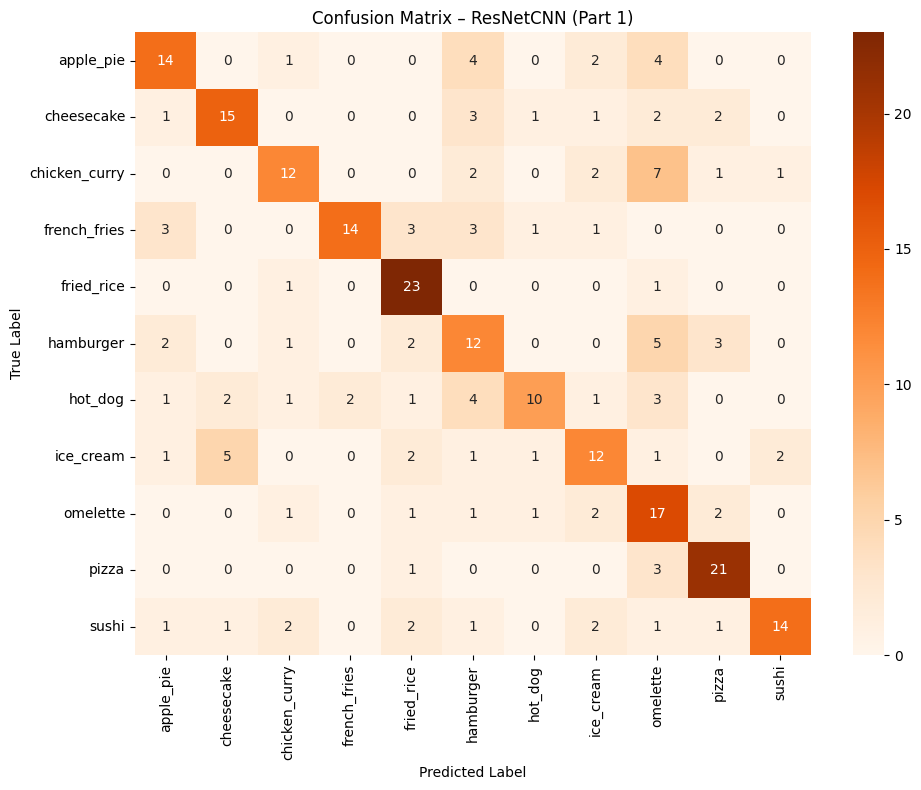

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# En iyi modeli yeniden oluştur ve eğit (batch32, lr0.0001)
best_model = ResNetCNN(num_classes=11).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=0.0001)

train_loader, val_loader = get_dataloaders(batch_size=32)

# Yeniden eğit (50 epoch)
for epoch in range(50):
    train_loss, train_acc = train_one_epoch(best_model, optimizer, criterion, train_loader, device)
    val_loss, val_acc = evaluate(best_model, criterion, val_loader, device)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/50] - Val Acc: {val_acc:.4f}")

# Test set üzerinde tahmin yap
best_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix oluştur
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix – ResNetCNN (Part 1)')
plt.tight_layout()
plt.show()


In [ ]:
# En iyi validation accuracy'yi bulalım
best_val_acc = 0.0
best_model_key = ''

for key, value in results.items():
    max_val_acc = max(value['val_accuracies'])
    if max_val_acc > best_val_acc:
        best_val_acc = max_val_acc
        best_model_key = key

print(f"Best Model: {best_model_key} with Validation Accuracy: {best_val_acc:.4f}")


Best Model: batch32_lr0.0001 with Validation Accuracy: 0.6655


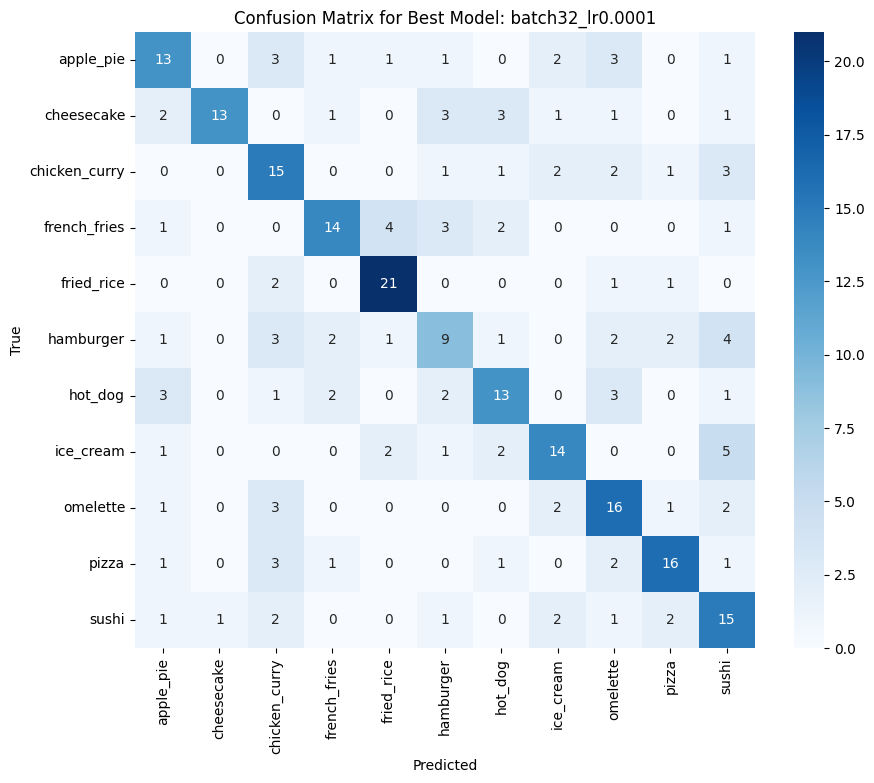

In [ ]:
# Best modeli yeniden eğit (veya eğitim sırasında kaydettiysen yükle)
best_batch_size = int(best_model_key.split('_')[0].replace('batch', ''))
best_lr = float(best_model_key.split('_')[1].replace('lr', ''))

# Modeli yeniden başlat ve eğit
best_model = SimpleCNN(num_classes=11).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_lr)
train_loader, val_loader = get_dataloaders(best_batch_size)

# 50 epoch eğit
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(best_model, optimizer, criterion, train_loader, device)
    val_loss, val_acc = evaluate(best_model, criterion, val_loader, device)

# Test verisiyle confusion matrix
best_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = best_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for Best Model: {best_model_key}')
plt.show()


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=11, dropout_rate=0.0):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate)
        )

        self.fc2 = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class ResNetCNN(nn.Module):
    def __init__(self, num_classes=11, dropout_rate=0.0):
        super(ResNetCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.residual_block1 = ResidualBlock(128)

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.residual_block2 = ResidualBlock(512)

        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate)
        )

        self.fc2 = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.residual_block1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.residual_block2(x)
        x = self.conv5(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


In [17]:
def run_experiment_with_dropout(ModelClass, model_label):
    dropout_rates = [0.3, 0.5]
    num_epochs = 50
    for rate in dropout_rates:
        print(f"\nTraining {model_label} with dropout rate {rate}")
        model = ModelClass(num_classes=11, dropout_rate=rate).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
        train_loader, val_loader = get_dataloaders(batch_size=32)

        val_accuracies = []

        for epoch in range(num_epochs):
            train_loss, train_acc = train_one_epoch(model, optimizer, criterion, train_loader, device)
            val_loss, val_acc = evaluate(model, criterion, val_loader, device)
            val_accuracies.append(val_acc)

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}] - Val Acc: {val_acc:.4f}")

        plt.plot(val_accuracies, label=f'Dropout {rate}')

    plt.title(f'{model_label} Validation Accuracy with Dropout')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.show()



Training SimpleCNN with dropout rate 0.3
Epoch [10] - Val Acc: 0.4327
Epoch [20] - Val Acc: 0.5236
Epoch [30] - Val Acc: 0.5564
Epoch [40] - Val Acc: 0.6436
Epoch [50] - Val Acc: 0.6509

Training SimpleCNN with dropout rate 0.5
Epoch [10] - Val Acc: 0.4218
Epoch [20] - Val Acc: 0.4800
Epoch [30] - Val Acc: 0.5636
Epoch [40] - Val Acc: 0.5491
Epoch [50] - Val Acc: 0.6618


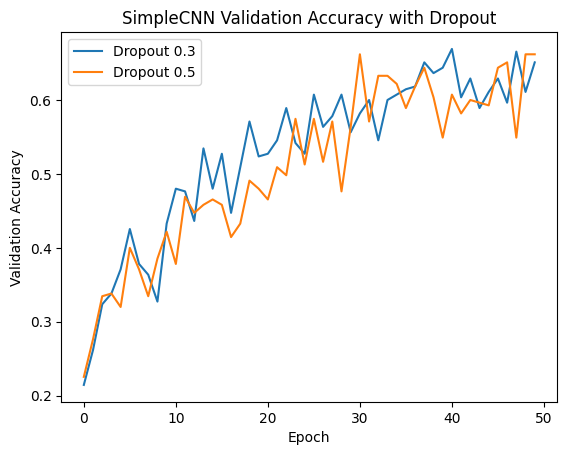


Training ResNetCNN with dropout rate 0.3
Epoch [10] - Val Acc: 0.4400
Epoch [20] - Val Acc: 0.5491
Epoch [30] - Val Acc: 0.5636
Epoch [40] - Val Acc: 0.6836
Epoch [50] - Val Acc: 0.6691

Training ResNetCNN with dropout rate 0.5
Epoch [10] - Val Acc: 0.3782
Epoch [20] - Val Acc: 0.5200
Epoch [30] - Val Acc: 0.5891
Epoch [40] - Val Acc: 0.6545
Epoch [50] - Val Acc: 0.6873


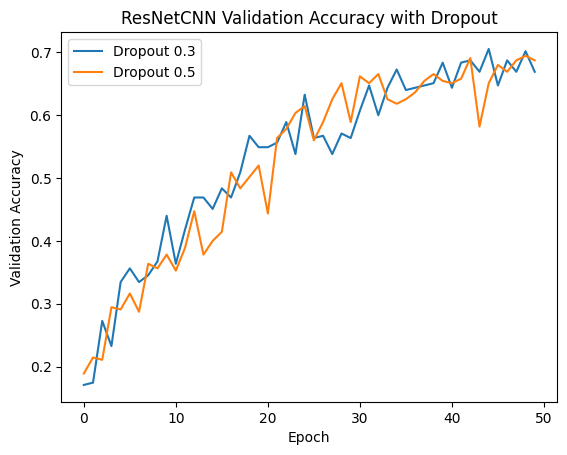

In [15]:
run_experiment_with_dropout(SimpleCNN, "SimpleCNN")
run_experiment_with_dropout(ResNetCNN, "ResNetCNN")


In [24]:
dropout_rates = [0.3, 0.5]
best_dropout = 0.0
best_val_acc = 0.0
model_label ="SimpleCNN"
for rate in dropout_rates:
    ...
    if max(val_accuracies) > best_val_acc:
        best_val_acc = max(val_accuracies)
        best_dropout = rate

print(f"Best Dropout Rate for {model_label}: {best_dropout}, Val Acc: {best_val_acc:.4f}")


Best Dropout Rate for SimpleCNN: 0.3, Val Acc: 0.6182


1. What is Fine-Tuning and Why Do We Freeze Layers?

Fine-tuning is a technique where we adapt a pre-trained model to a new task. In this case, I used MobileNetV2, pre-trained on ImageNet, and fine-tuned it for the Food-11 classification task. The early layers of CNNs learn general features like edges and textures that are useful for most images, so I froze those layers to keep their weights fixed and only trained the final fully connected (FC) layer. This reduces training time and helps avoid overfitting, especially with a smaller dataset. I also tried unfreezing the last two convolutional blocks along with the FC layer, which improved performance. The model with only the FC layer reached 88.36% validation accuracy, while the second setup achieved 90.18%. Below is the code I used to freeze and modify the model:

In [ ]:
def prepare_model(num_classes=11, unfreeze_last_blocks=False):
    model = models.mobilenet_v2(pretrained=True)

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Optionally unfreeze last two convolutional blocks
    if unfreeze_last_blocks:
        for name, param in model.features[-2:].named_parameters():
            param.requires_grad = True

    # Replace classifier
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)  # New FC layer
    return model.to(device)


In [ ]:
def train_finetune_model(model, train_loader, val_loader, lr=0.001, epochs=15):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    history = {'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

    return model, history


In [ ]:
# Only FC layer
model_fc_only = prepare_model(num_classes=11, unfreeze_last_blocks=False)
model_fc_only, history_fc = train_finetune_model(model_fc_only, train_loader, val_loader)

# Last two conv + FC layer
model_partial = prepare_model(num_classes=11, unfreeze_last_blocks=True)
model_partial, history_partial = train_finetune_model(model_partial, train_loader, val_loader)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 99.8MB/s]


Epoch 1: Train Acc = 0.3891, Val Acc = 0.7455
Epoch 2: Train Acc = 0.6127, Val Acc = 0.8400
Epoch 3: Train Acc = 0.6300, Val Acc = 0.8218
Epoch 4: Train Acc = 0.6664, Val Acc = 0.8545
Epoch 5: Train Acc = 0.6768, Val Acc = 0.8545
Epoch 6: Train Acc = 0.6773, Val Acc = 0.8582
Epoch 7: Train Acc = 0.6895, Val Acc = 0.8400
Epoch 8: Train Acc = 0.7000, Val Acc = 0.8655
Epoch 9: Train Acc = 0.6900, Val Acc = 0.8582
Epoch 10: Train Acc = 0.6909, Val Acc = 0.8618
Epoch 11: Train Acc = 0.6914, Val Acc = 0.8800
Epoch 12: Train Acc = 0.7105, Val Acc = 0.8764
Epoch 13: Train Acc = 0.7095, Val Acc = 0.8800
Epoch 14: Train Acc = 0.7036, Val Acc = 0.8836
Epoch 15: Train Acc = 0.7045, Val Acc = 0.8764
Epoch 1: Train Acc = 0.5636, Val Acc = 0.8509
Epoch 2: Train Acc = 0.6950, Val Acc = 0.8509
Epoch 3: Train Acc = 0.7050, Val Acc = 0.8691
Epoch 4: Train Acc = 0.7409, Val Acc = 0.8764
Epoch 5: Train Acc = 0.7314, Val Acc = 0.8727
Epoch 6: Train Acc = 0.7495, Val Acc = 0.8873
Epoch 7: Train Acc = 0.7745,

In [ ]:
print(f"FC only best val acc: {max(history_fc['val_acc']):.4f}")
print(f"Last conv + FC best val acc: {max(history_partial['val_acc']):.4f}")


FC only best val acc: 0.8836
Last conv + FC best val acc: 0.9018


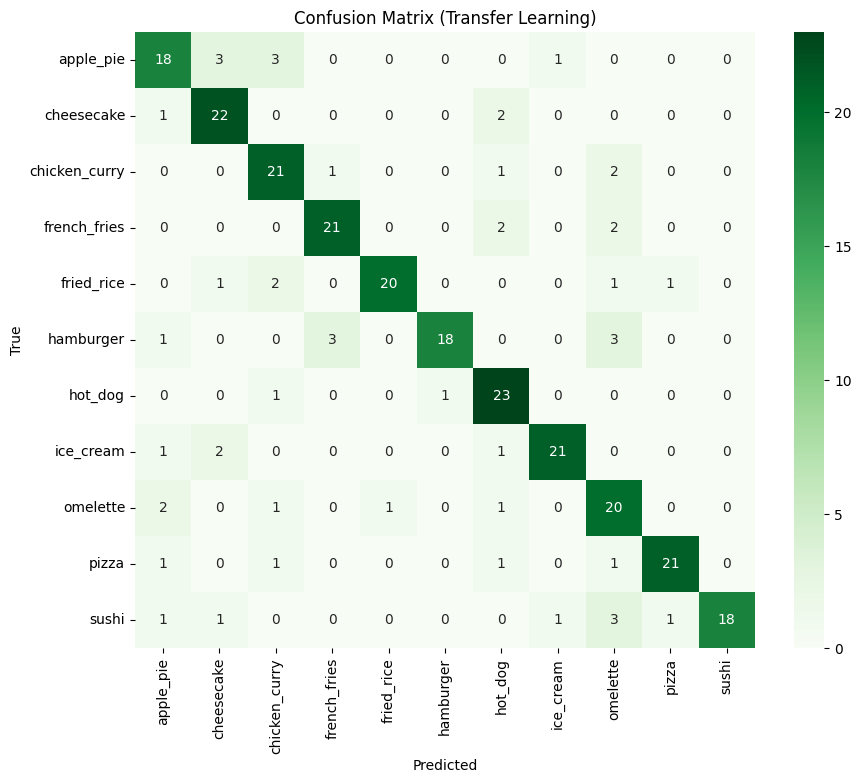

In [ ]:
# En iyi modeli test et
def plot_confusion_matrix(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Transfer Learning)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# En iyi modeli belirle
best_model_tl = model_partial if max(history_partial['val_acc']) > max(history_fc['val_acc']) else model_fc_only
plot_confusion_matrix(best_model_tl, test_loader)
